In [1]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import numpy as np
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
import joblib

In [2]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end:.2f}, Anh end regret {Anh_end:.2f}, \n
    Anh better {Anhst} ''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

def plot_perstepavg_allgroups(cumreg_groupwise_oridge, Anh):
  plt.xlabel("Time slots")
  plt.ylabel("Regret")
  # for gnum in range(len(cumreg_groupwise_oridge)):  
  for gnum in range(2):
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    # Anh_curve = Anh.cuml_regret_curve[gnum] # Anh curve for this group
    time_steps = np.arange(1, Tg+1)
    # plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'--', label = f"Online Ridge (OR) {gnum}")
    # plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-', label = f"Anh{gnum}")
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum] / time_steps,'--', label = f"Online Ridge average (OR) {gnum}")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum] / time_steps ,'-', label = f"Anh average{gnum}")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df_all = pd.read_pickle("allstates2021.pkl") 
df_all.dtypes # only AGEP, WKHP, PINCP are numeric, rest are ints (one hot encoded)

AGEP       float64
WKHP       float64
PINCP      float64
COW_1        uint8
COW_2        uint8
            ...   
RAC1P_5      uint8
RAC1P_6      uint8
RAC1P_7      uint8
RAC1P_8      uint8
RAC1P_9      uint8
Length: 301, dtype: object

In [5]:
X_dat = df_all.drop('PINCP', axis=1) #dropping the income column
y_dat = pd.DataFrame(df_all['PINCP']) # picking up only the income column for the target

In [6]:
gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9'] #sensitive group names
sensitive_group_cols = X_dat[gnames] # this picks the above columns from X_dat dataframe
A_tarr = sensitive_group_cols.to_numpy()

In [7]:
N = A_tarr.shape[1] # number of meta-experts
d = len(X_dat.columns) # dimensionality of features
T = len(X_dat) # number of rounds of interaction, basically # of rows of data
print(N, d, T)

11 300 1428283


# plotting Anh vs Online ridge always active (implementable version) on 11 groups

In [8]:
with open('Anh_all_with_cumreg.pkl', 'rb') as f:
    Anh = pickle.load(f)

In [33]:
Anh.N

11

In [9]:
bls_undrop = joblib.load('bls_together_undroppedjoblib.pkl') # all columns intact

In [10]:
with open('loss_oridge_all_alwaysactive.pkl', 'rb') as f:
    loss_tarr = pickle.load(f)

loss_groupwise_oridge = []
cumloss_groupwise_oridge = []
cumreg_groupwise_oridge = []
loss_oridge_tarr = np.array(loss_tarr)

for gnum in range(N): # build cumulative loss for  on each group subsequence
    loss_groupwise_oridge.append(loss_oridge_tarr[A_tarr[:, gnum].astype(bool)]) # select those losses where group gnum active
    cumloss_groupwise_oridge.append(np.cumsum(loss_groupwise_oridge[-1])) #cumulative sum of the previous
    cumreg_groupwise_oridge.append(cumloss_groupwise_oridge[-1] - bls_undrop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [ ]:
# better on 10 out of 11 groups
plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh)

# plotting Anh vs Online ridge on subsequences (not implementable version) on 11 groups

In [12]:
cumloss_groupwise_ridgesubseq = [] #online ridge cumulative regret
cumreg_groupwise_ridgesubseq = []

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_undrop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

Group number 0, Tg is 722240 

    oridge end regret 9437.46, Anh end regret 9436.61, 

    Anh better Yes 


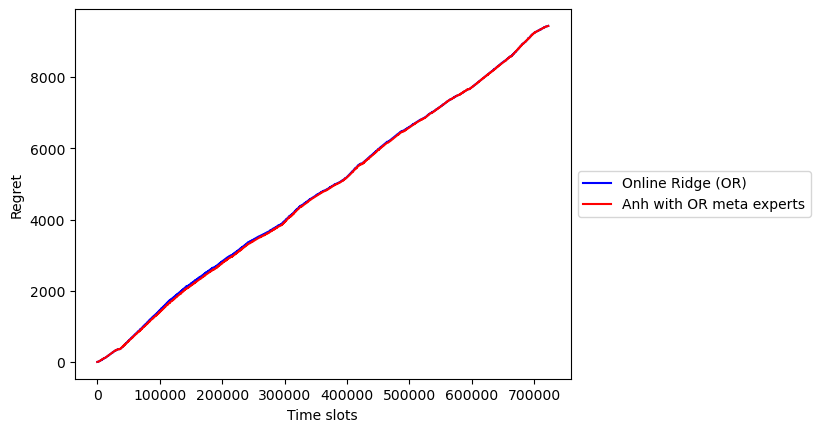

Group number 1, Tg is 706043 

    oridge end regret 8167.72, Anh end regret 8026.01, 

    Anh better Yes 


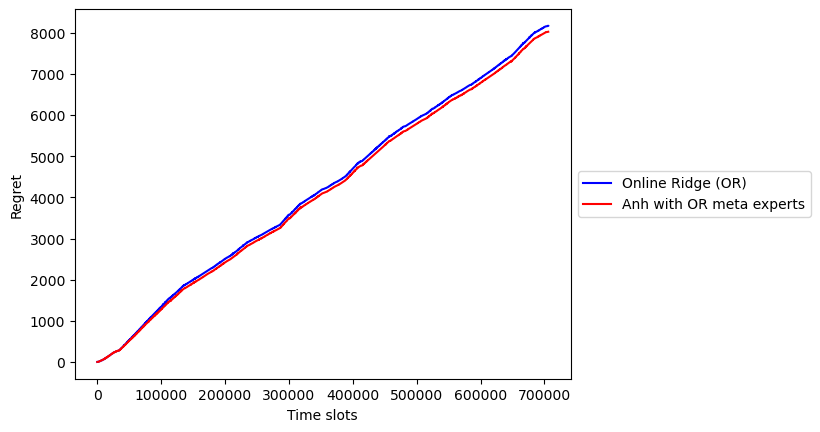

Group number 2, Tg is 948630 

    oridge end regret 12378.26, Anh end regret 12126.52, 

    Anh better Yes 


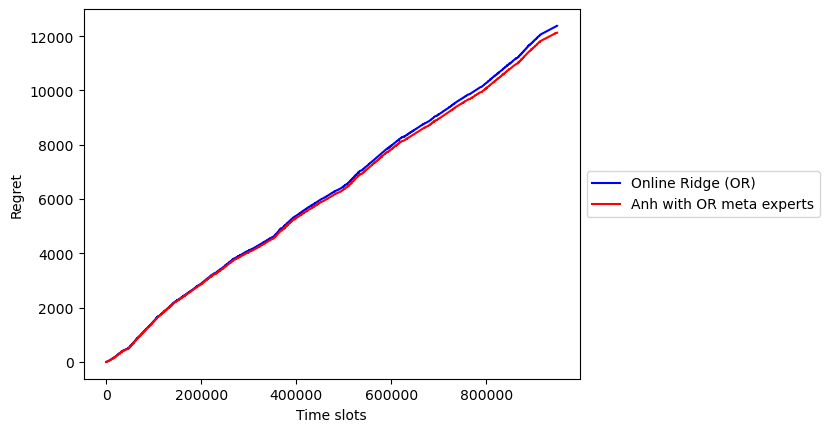

Group number 3, Tg is 124853 

    oridge end regret 977.35, Anh end regret 976.68, 

    Anh better Yes 


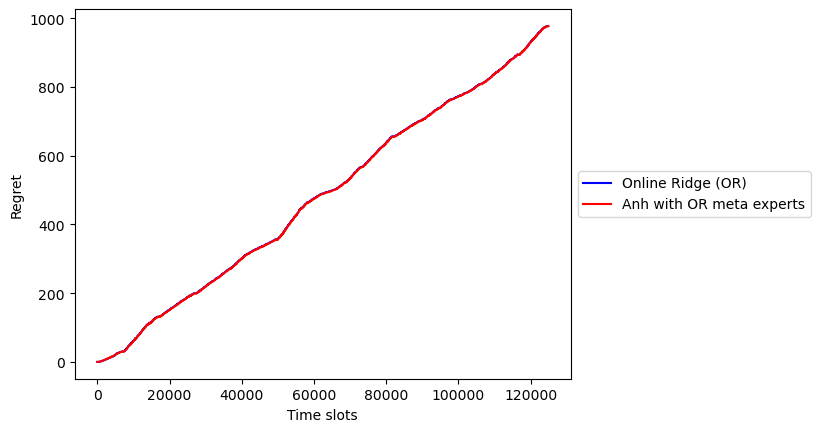

Group number 4, Tg is 13066 

    oridge end regret 71.09, Anh end regret 71.86, 

    Anh better No 


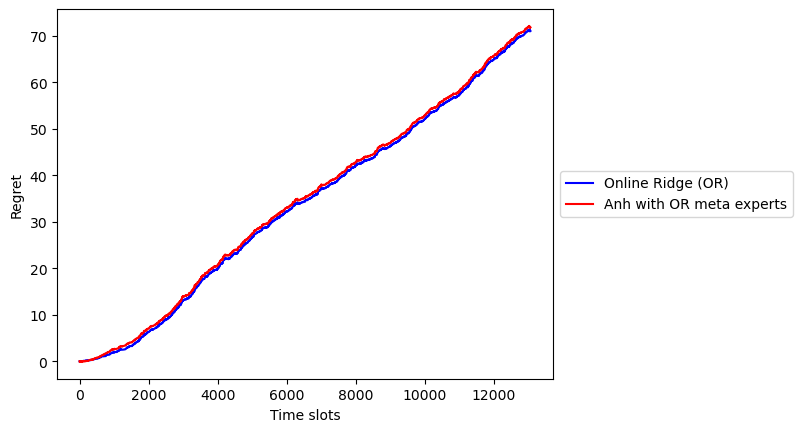

Group number 5, Tg is 613 

    oridge end regret 1.25, Anh end regret 1.41, 

    Anh better No 


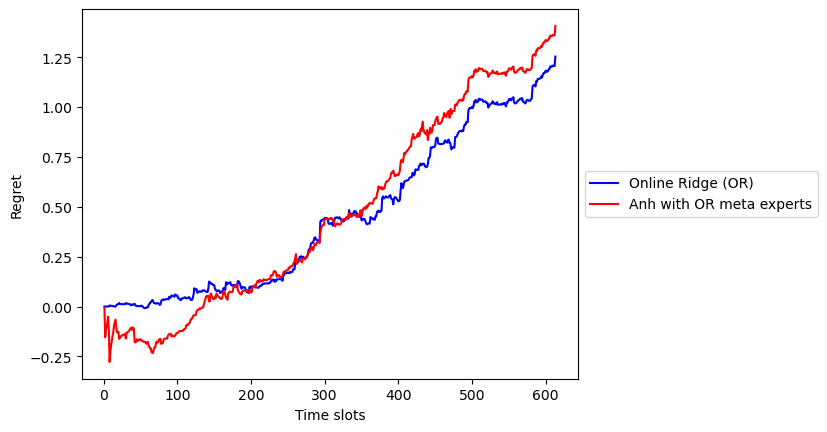

Group number 6, Tg is 2110 

    oridge end regret 7.99, Anh end regret 7.77, 

    Anh better Yes 


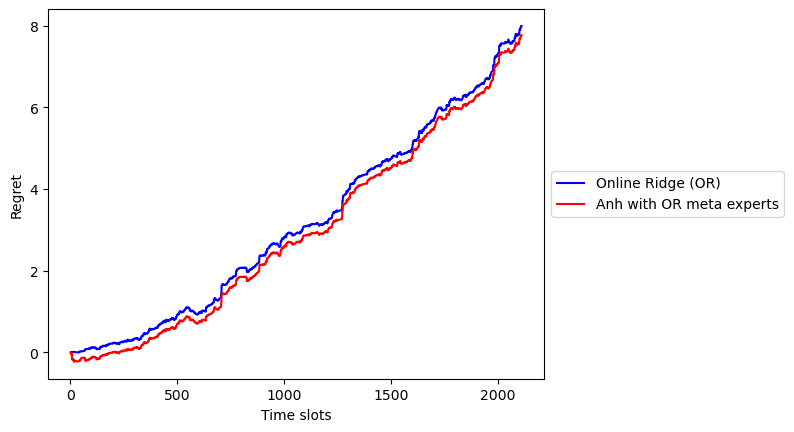

Group number 7, Tg is 92707 

    oridge end regret 1756.06, Anh end regret 1757.44, 

    Anh better No 


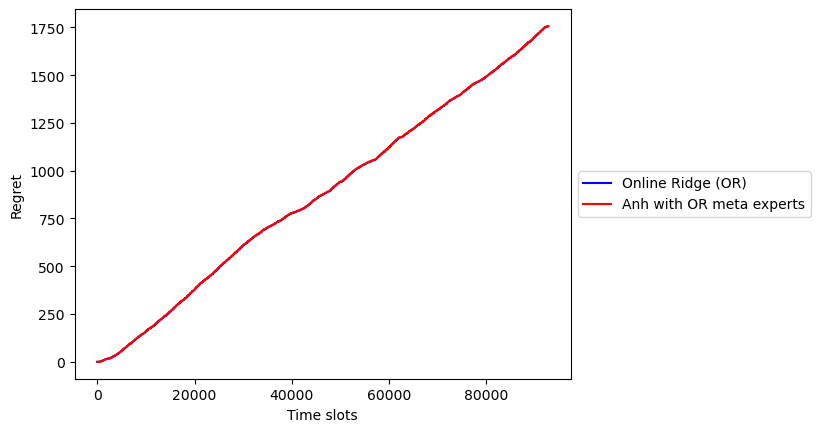

Group number 8, Tg is 2486 

    oridge end regret 9.01, Anh end regret 8.72, 

    Anh better Yes 


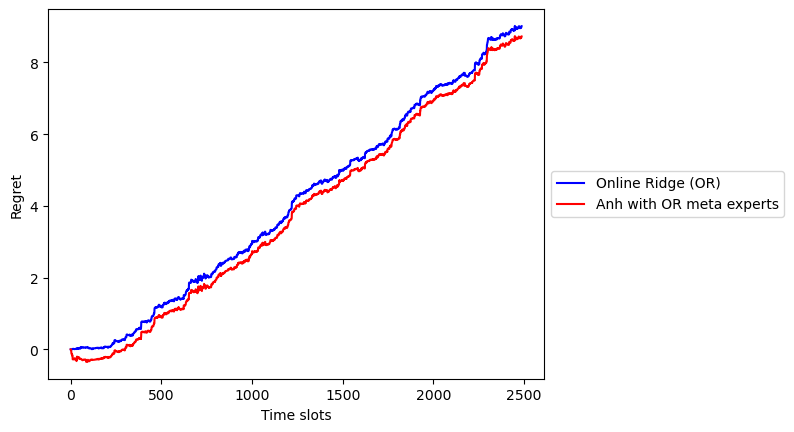

Group number 9, Tg is 89974 

    oridge end regret 599.45, Anh end regret 600.97, 

    Anh better No 


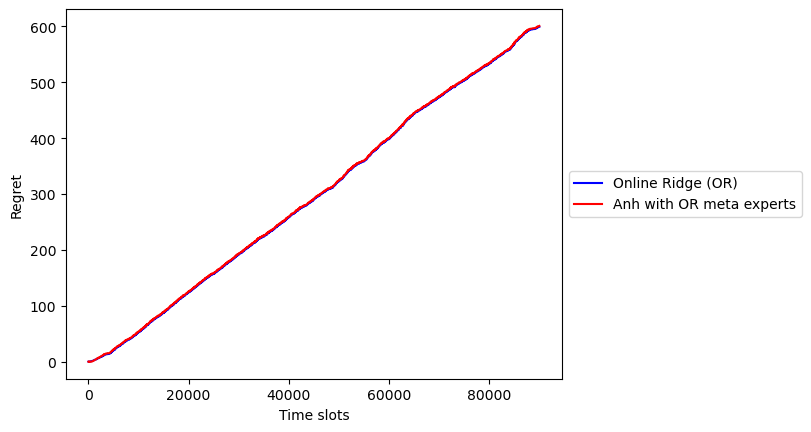

Group number 10, Tg is 153844 

    oridge end regret 1697.53, Anh end regret 1689.89, 

    Anh better Yes 


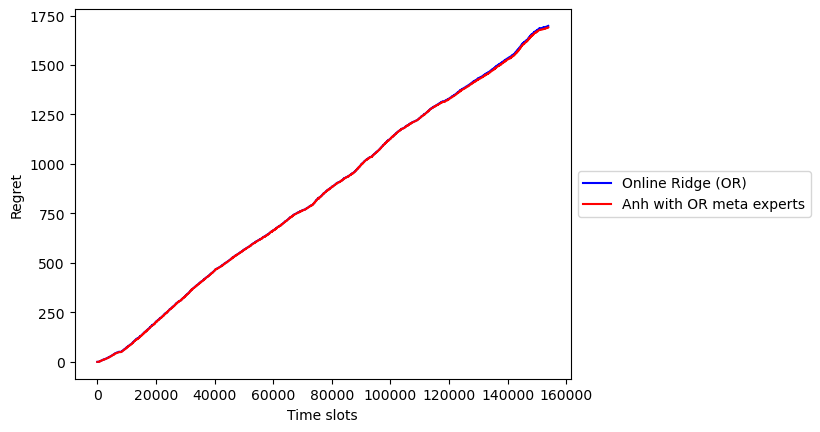

Anh better for 7 out of 11 groups


In [13]:
 # better on 7/11 not bad
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh)

# Anh vs Online ridge (implementable), undropped columns, 12 groups

In [29]:
def get_subsequence_regrets_forORidge(loss_tarr, A_tarr, bestsqloss_arr):
    '''
    loss_tarr is online ridge (implementable) loss per round
    mask the groups and get subsequence regret for the online ridge model which is always active
    A_tarr has shape size of (dataframe x number of groups)
    bestsqloss_arr has the best in hindsight sqloss cumulative for each group, (is a list)
    '''
    N = A_tarr.shape[1]
    loss_groupwise_oridge = []
    cumloss_groupwise_oridge = []
    cumreg_groupwise_oridge = []
    loss_oridge_tarr = np.array(loss_tarr)
    for gnum in range(N): # build cumulative loss for  on each group subsequence
        loss_groupwise_oridge.append(loss_oridge_tarr[A_tarr[:, gnum].astype(bool)]) # select those losses where group gnum active
        cumloss_groupwise_oridge.append(np.cumsum(loss_groupwise_oridge[-1])) #cumulative sum of the previous
        cumreg_groupwise_oridge.append(cumloss_groupwise_oridge[-1] - np.array(bestsqloss_arr[gnum])) #bestsquare loss for that group subsequence still the same
    return cumreg_groupwise_oridge

In [32]:
with open('loss_oridge_all_alwaysactive.pkl', 'rb') as f:
    loss_tarr = pickle.load(f)
cumreg_groupwise_oridge = get_subsequence_regrets_forORidge(loss_tarr, A_tarr_plus, bls_undrop.best_sqloss)

In [ ]:
# better on 10 out of 12 groups, got worse for 2 or more races
plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh_plus_notdropped)

# plotting Anh vs online ridge on subsequences (not implementable) on 12 groups - including always active group, undropped sensitive columns


In [39]:
X_dat = df_all.drop('PINCP', axis=1) #dropping the income column
y_dat = pd.DataFrame(df_all['PINCP']) # picking up only the income column for the target

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9'] #sensitive group names
sensitive_group_cols = X_dat[gnames] # this picks the above columns from X_dat dataframe
sensitive_group_cols['always_on'] = 1
A_tarr_plus = sensitive_group_cols.to_numpy()
print(A_tarr_plus.shape)

(1428283, 12)


/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_8645/1993206460.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitive_group_cols['always_on'] = 1


In [40]:
with open('Anh_plus_alwaysactive.pkl', 'rb') as f:
    Anh_plus_notdropped = pickle.load(f)

In [41]:
Anh_plus_notdropped.N

12

In [42]:
Anh_plus_notdropped.build_cumloss_curve(bls_undrop.best_sqloss, A_tarr_plus)

In [43]:
cumloss_groupwise_ridgesubseq = [] #online ridge cumulative regret, not implementable
cumreg_groupwise_ridgesubseq = []

for gnum in range(Anh_plus_notdropped.N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_plus_notdropped.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_undrop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [ ]:
#better for 8 out of 12 groups
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_plus_notdropped)

# Anh vs Online ridge on subseqeunce(not implementable), with dropped columns, 12 groups

In [20]:
with open('Anh_plus_alwaysactive_dropped.pkl', 'rb') as f:
    Anh_plus_dropped = pickle.load(f)

In [21]:
print(Anh_plus_dropped.N)
print(Anh_plus_dropped.cuml_regret_curve) # need to build the regret curve with best square loss dropped

12
[]


In [47]:
bls_drop = joblib.load('bls_together_plusone_dropped.pkl') # all columns intact

In [23]:
Anh_plus_dropped.build_cumloss_curve(bls_drop.best_sqloss, A_tarr_plus)

In [24]:
cumloss_groupwise_ridgesubseq = [] #online ridge cumulative regret
cumreg_groupwise_ridgesubseq = []

for gnum in range(Anh_plus_dropped.N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_plus_dropped.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_drop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [ ]:
# better on 8 out of 12
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_plus_dropped) 

# Anh vs Online ridge (implementable), dropped columns, 12 groups

In [45]:
with open('oridge_alwaysactive_droppedobj.pkl', 'rb') as f:
    oridge_alwaysactive_dropped = pickle.load(f) # smaller size thats good, because deleted dataframes

In [48]:
oridge_alwaysactive_dropped.fill_subsequence_regrets(A_tarr_plus, bls_drop.best_sqloss)

Group number 0, Tg is 722240 

    oridge end regret 11026.81, Anh end regret 9684.06, 

    Anh better Yes 


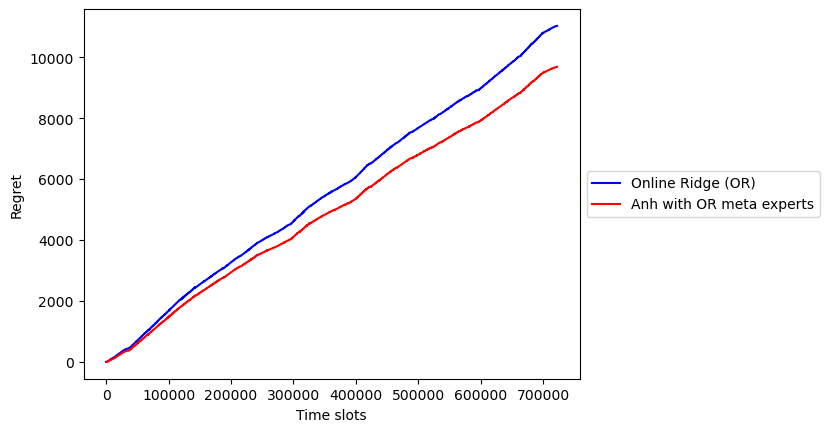

Group number 1, Tg is 706043 

    oridge end regret 8923.10, Anh end regret 8230.93, 

    Anh better Yes 


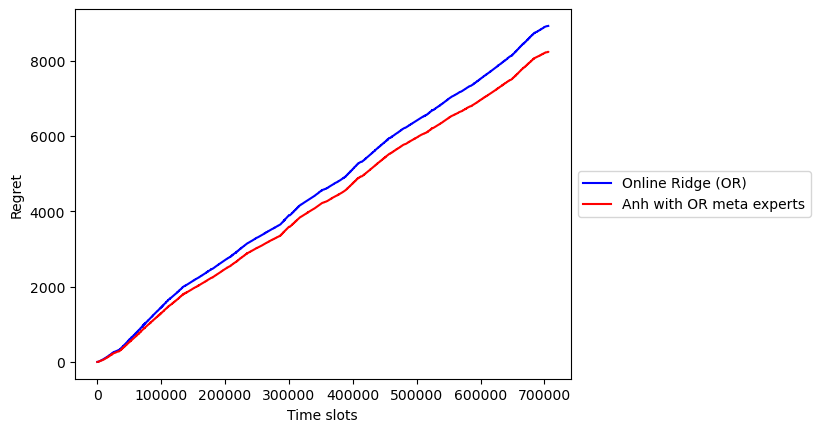

Group number 2, Tg is 948630 

    oridge end regret 13319.68, Anh end regret 12064.85, 

    Anh better Yes 


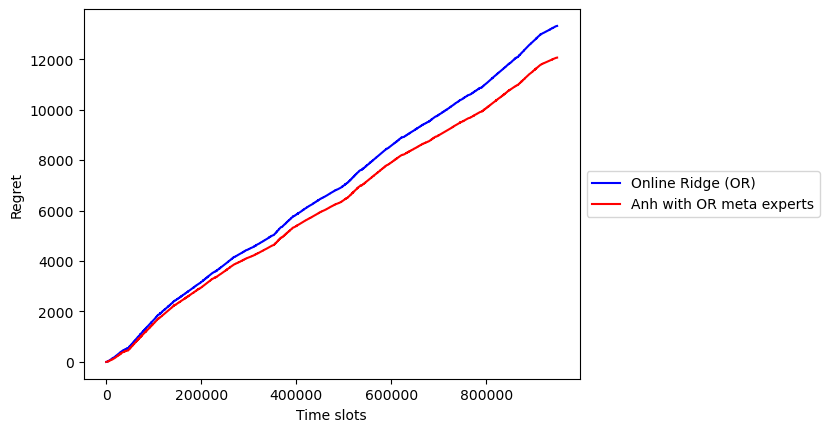

Group number 3, Tg is 124853 

    oridge end regret 1084.18, Anh end regret 978.14, 

    Anh better Yes 


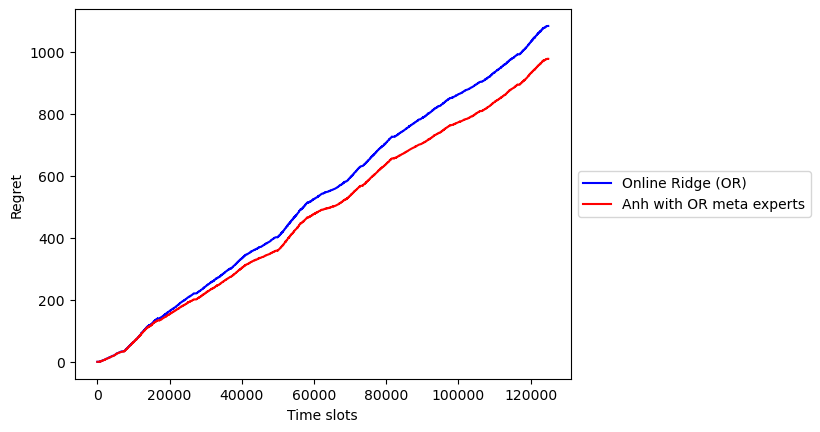

Group number 4, Tg is 13066 

    oridge end regret 97.37, Anh end regret 72.93, 

    Anh better Yes 


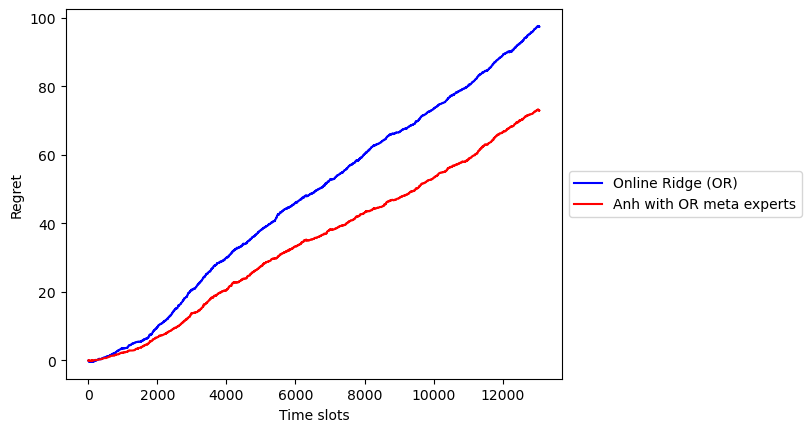

Group number 5, Tg is 613 

    oridge end regret 2.33, Anh end regret 1.78, 

    Anh better Yes 


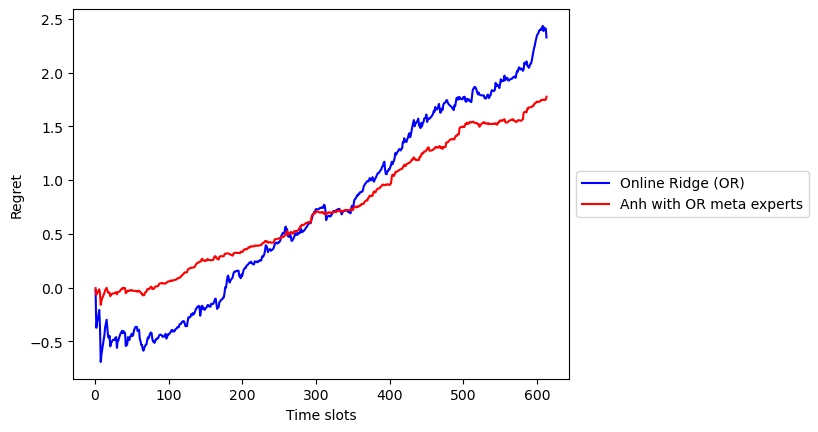

Group number 6, Tg is 2110 

    oridge end regret 12.43, Anh end regret 8.02, 

    Anh better Yes 


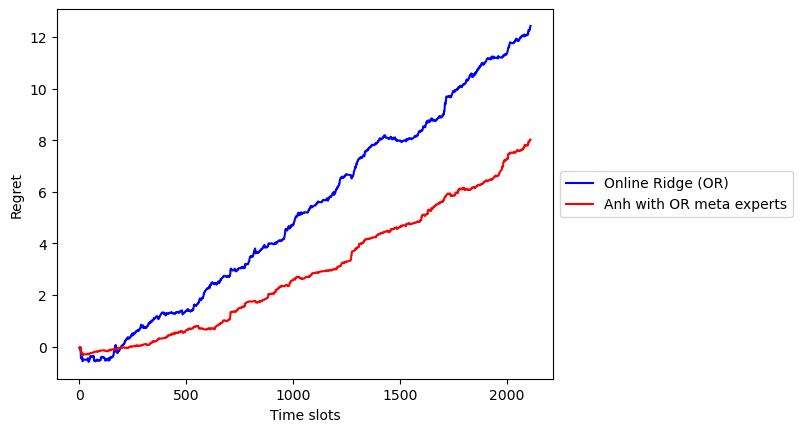

Group number 7, Tg is 92707 

    oridge end regret 1981.05, Anh end regret 1801.38, 

    Anh better Yes 


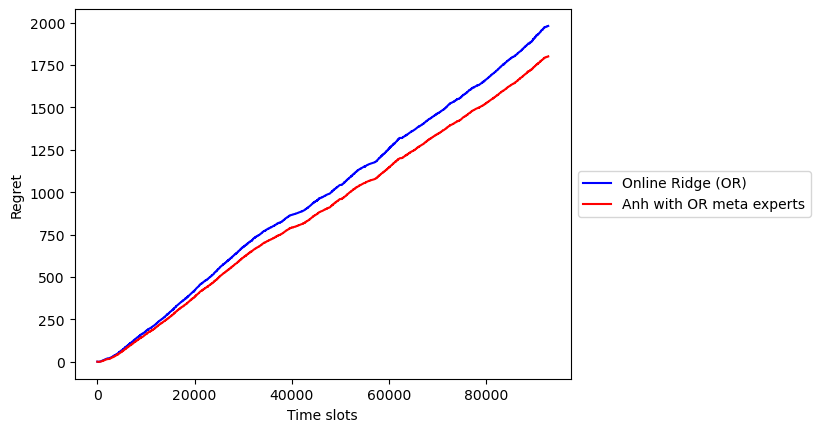

Group number 8, Tg is 2486 

    oridge end regret 10.59, Anh end regret 9.15, 

    Anh better Yes 


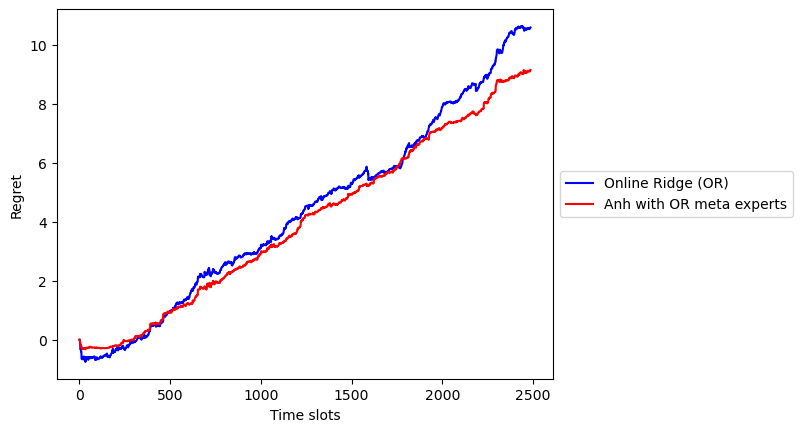

Group number 9, Tg is 89974 

    oridge end regret 962.10, Anh end regret 617.65, 

    Anh better Yes 


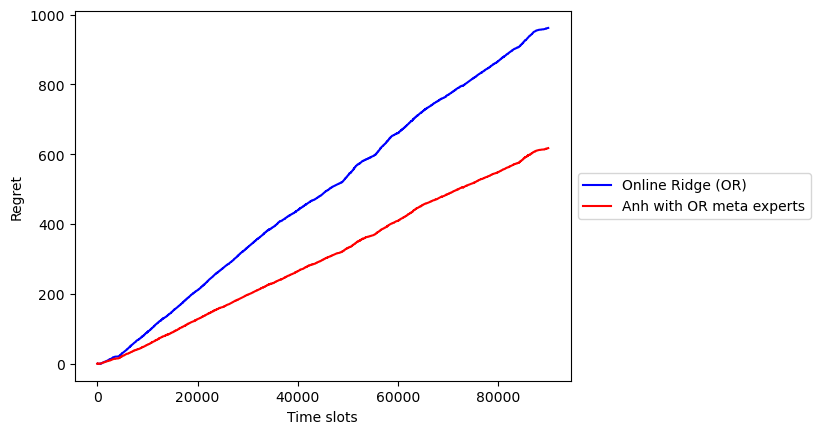

Group number 10, Tg is 153844 

    oridge end regret 1854.77, Anh end regret 1735.66, 

    Anh better Yes 


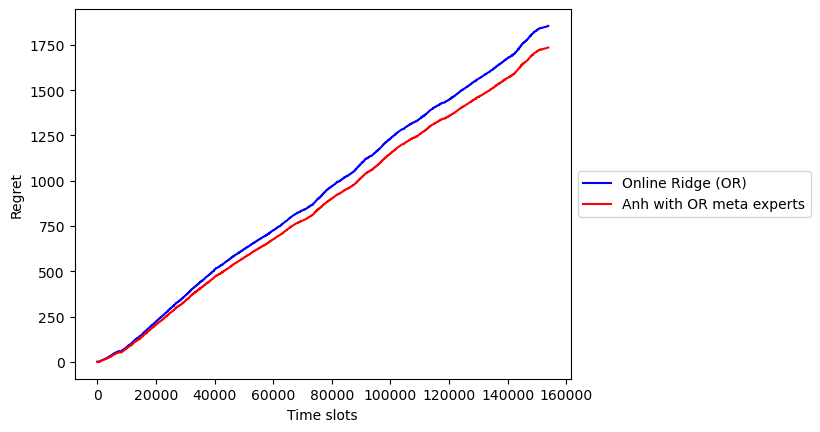

Group number 11, Tg is 1428283 

    oridge end regret 19263.90, Anh end regret 17228.97, 

    Anh better Yes 


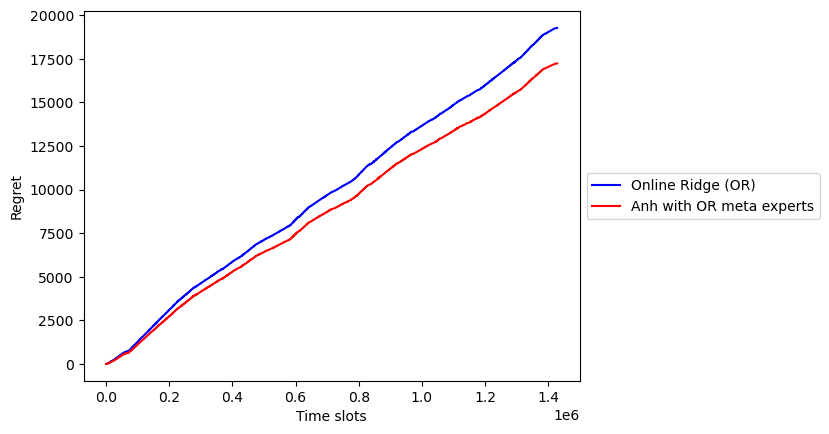

Anh better for 12 out of 12 groups


In [49]:
#better on 12 out of 12 
plot_ORidgevsAnh_together(oridge_alwaysactive_dropped.cumreg_groupwise_oridge, Anh_plus_dropped)